White light structure intensity changes
---
This notebook illustrates how to predict the white-light signal of a number density structure.

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
import scipy.optimize as opt

from astropy.constants import R_sun, au
import astropy.units as u

from methods import integrand_background, G_tot

r_sun_AU = float(R_sun / au)  # Radius of the Sun in AU

The change in intensity when a blob is present is given by
$$ \frac{\delta I}{I_{0}} = \delta z \left [ \frac{\delta n}{n_{0}} \right ] f \left (r_{0}, r_{obs} \right ) $$

Where $\delta z$ is the blob width along the line of sight, $\delta n / n_{0}$ is the blob density over the background density, $r_{0}$ is the distance of the blob from the centre of the Sun, and $r_{obs}$ is the disntance of the observer from the centre of the Sun. See Appendix 1 in the paper for a derivation of this.

The higher the value of $f$, the more visible blobs are.

The function $f \left (r_{0}, r_{obs} \right )$ is given by
$$
    f \left ( r_{0}, r_{obs} \right ) = \frac{n_{e} \left ( r_{0} \right ) G \left ( r_{0} \right ) z_{0}^{2}}{I_{0} \left ( r_{0}, r_{obs} \right )}
$$
The units of $f \left ( r_{0} \right )$ are inverse length.

Definte a function to get the direction of the blob, given it lives on the Thompson sphere:

In [12]:
def r_to_eps(r, r_obs):
    '''
    Returns Sun - Earth - blob angle assuming
    blob lies on the Thompson sphere.
    
    r is sun-blob distance
    r_obs is sun-observer distance
    '''
    return np.arcsin(r / r_obs)

Now implement the f function defined above:

In [13]:
def f(r, r_obs):
    eps = r_to_eps(r, r_obs)
    # Numerically evaluate the background intensity
    I0 = integrate.quad(integrand_background, 0, np.inf, args=(eps, r_obs))[0]
    # Take a 1/r^2 background number density
    ne = 1 / r**2
    # At large distances, this is the approximate form of the G function
    G = (r / r_sun_AU)**-2
    return G * ne / I0

We can now plot f. We do this for observers at 1 AU and 0.3 AU.

For small blob distances from the Sun, (at least $<$ 0.5 AU for the observer at 1 AU) the function is linear when plotted on a log-log scale.

Fitted slope: 0.6358057370619518


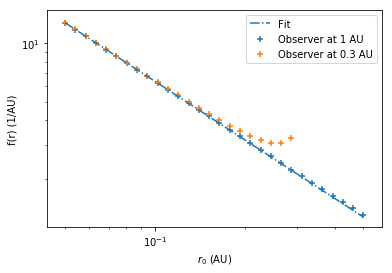

In [14]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
rs = np.logspace(np.log10(0.05), np.log10(0.5), 30)
fs_1 = [f(r, 1) for r in rs]

fs_1 = [f(r, 1) for r in rs]
ax.scatter(rs, fs_1, label='Observer at 1 AU', marker='+')

fs_point3 = [f(r, 0.3) for r in rs[rs < 0.3]]
ax.scatter(rs[rs < 0.3], fs_point3, label='Observer at 0.3 AU', marker='+')

# Fit a line of the form f(r) = a / r
def fit(r, a):
    return a / r

popt, pcov = opt.curve_fit(fit, rs, fs_1, p0=(0.66))
print('Fitted slope: {}'.format(popt[0]))
ax.plot(rs, fit(rs, popt[0]), label='Fit', linestyle='-.')

ax.legend()
ax.set_xlabel('$r_{0}$ (AU)')
ax.set_ylabel('f(r) (1/AU)');

We see that $1/f(r_{0})$ is linear with $r_{0}$, with $f(r_{0})\cdot r_{0} \approx 0.64$. This gives the relation
$$ f(r_{0}) \approx \frac{0.64}{r_{0}}$$
which leads to
$$
\frac{\delta I}{I_{0}} = 0.64 \frac{\delta z}{r_{0}} \frac{\delta n}{n}
$$